In [230]:
# Import required libraries for data analysis and visualization
import pandas as pd      # for data manipulation and analysis
import numpy as np       # for numerical operations
from plotnine import *   # for grammar of graphics visualization (ggplot2 style)
import matplotlib.pyplot as plt  # for additional plotting capabilities
import warnings
from IPython.display import display
import os


# Configure display and warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Modeling tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

In [231]:
# Set up plotnine global theme for consistent, professional-looking charts
theme_set(theme_minimal() + 
          theme(figure_size=(18, 8),
                text=element_text(size=11),
                plot_title=element_text(size=16, fontweight='bold'),
                plot_subtitle=element_text(size=12, fontstyle='italic'),
                axis_title=element_text(size=12),
                axis_text=element_text(size=10),
                legend_text=element_text(size=10),
                legend_position='bottom'))

In [234]:
RAW_CSV = 'Case_Data.csv' # Path to the raw data CSV file
# All outputs go here
OUT_DIR = 'processed_data'
os.makedirs(OUT_DIR, exist_ok=True)


In [235]:
# # Load and examine basic dataset information
df = pd.read_csv(RAW_CSV)
print("Dataset shape:") 
df.shape

Dataset shape:


(20000, 68)

In [236]:
# quick peek
print('\nHead:')
display(df.head())


Head:


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,Cash loans,M,Y,N,1,225000.0,918468.0,28966.5,697500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.016612,-14086,-3028,-643,-4911,1,0,1,0,0,Drivers,3,2,2,THURSDAY,13,0,0,0,0,0,0,Self-employed,0.566907,0.770087,0.0,0.0,0.0,0.0,-4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,M,Y,Y,0,157500.0,299772.0,20160.0,247500.0,Family,Working,Secondary / secondary special,Single / not married,Rented apartment,0.020713,-8728,-1157,-3494,-1368,1,0,1,0,0,Laborers,1,3,3,SATURDAY,6,0,0,0,1,1,0,Business Entity Type 2,0.346634,0.678568,0.0,0.0,0.0,0.0,-925,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,Cash loans,M,N,N,0,108000.0,509602.5,26149.5,387000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018634,-12931,-1317,-6392,-3866,1,0,1,0,0,Drivers,2,2,2,THURSDAY,12,0,0,0,1,1,0,Government,0.236378,0.062103,0.0,0.0,0.0,0.0,-3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,Cash loans,F,N,Y,0,90000.0,225000.0,11074.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.028663,-19334,-3494,-2419,-2893,1,0,1,1,0,Cleaning staff,2,2,2,SATURDAY,8,0,0,0,0,0,0,Business Entity Type 3,0.651406,0.461482,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Cash loans,F,N,Y,0,112500.0,512064.0,25033.5,360000.0,Family,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008575,-11144,-1104,-7846,-2904,1,0,1,0,0,Private service staff,2,2,2,TUESDAY,12,0,0,0,0,0,0,Services,0.627300,NaN,2.0,0.0,2.0,0.0,-397,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,5.0


In [237]:

# structure
print('\nInfo:')
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET                       20000 non-null  int64  
 1   NAME_CONTRACT_TYPE           20000 non-null  object 
 2   CODE_GENDER                  20000 non-null  object 
 3   FLAG_OWN_CAR                 20000 non-null  object 
 4   FLAG_OWN_REALTY              20000 non-null  object 
 5   CNT_CHILDREN                 20000 non-null  int64  
 6   AMT_INCOME_TOTAL             20000 non-null  float64
 7   AMT_CREDIT                   20000 non-null  float64
 8   AMT_ANNUITY                  19998 non-null  float64
 9   AMT_GOODS_PRICE              19978 non-null  float64
 10  NAME_TYPE_SUITE              19919 non-null  object 
 11  NAME_INCOME_TYPE             20000 non-null  object 
 12  NAME_EDUCATION_TYPE          20000 non-null  object 
 13  NAME_FAMI

In [238]:
print(f"Target distribution:")
print(df['TARGET'].value_counts(normalize=True))

Target distribution:
TARGET
0    0.92255
1    0.07745
Name: proportion, dtype: float64


In [239]:
# Analyze our target variable - who had payment difficulties vs who didn't
target_counts = df['TARGET'].value_counts().sort_index()
target_pct = df['TARGET'].value_counts(normalize=True).sort_index() * 100

print("Target Variable Distribution:")
print(f"  0 (No Payment Difficulties): {target_counts[0]:,} ({target_pct[0]:.1f}%)")
print(f"  1 (Payment Difficulties):    {target_counts[1]:,} ({target_pct[1]:.1f}%)")

# Prepare df for visualization
target_summary = (df.groupby('TARGET')
                 .size()
                 .reset_index(name='count')
                 .assign(
                     percentage=lambda x: round(x['count'] / x['count'].sum() * 100, 1),
                     label=lambda x: x['TARGET'].map({0: 'No Payment Difficulties', 1: 'Payment Difficulties'})
                 ))

Target Variable Distribution:
  0 (No Payment Difficulties): 18,451 (92.3%)
  1 (Payment Difficulties):    1,549 (7.7%)


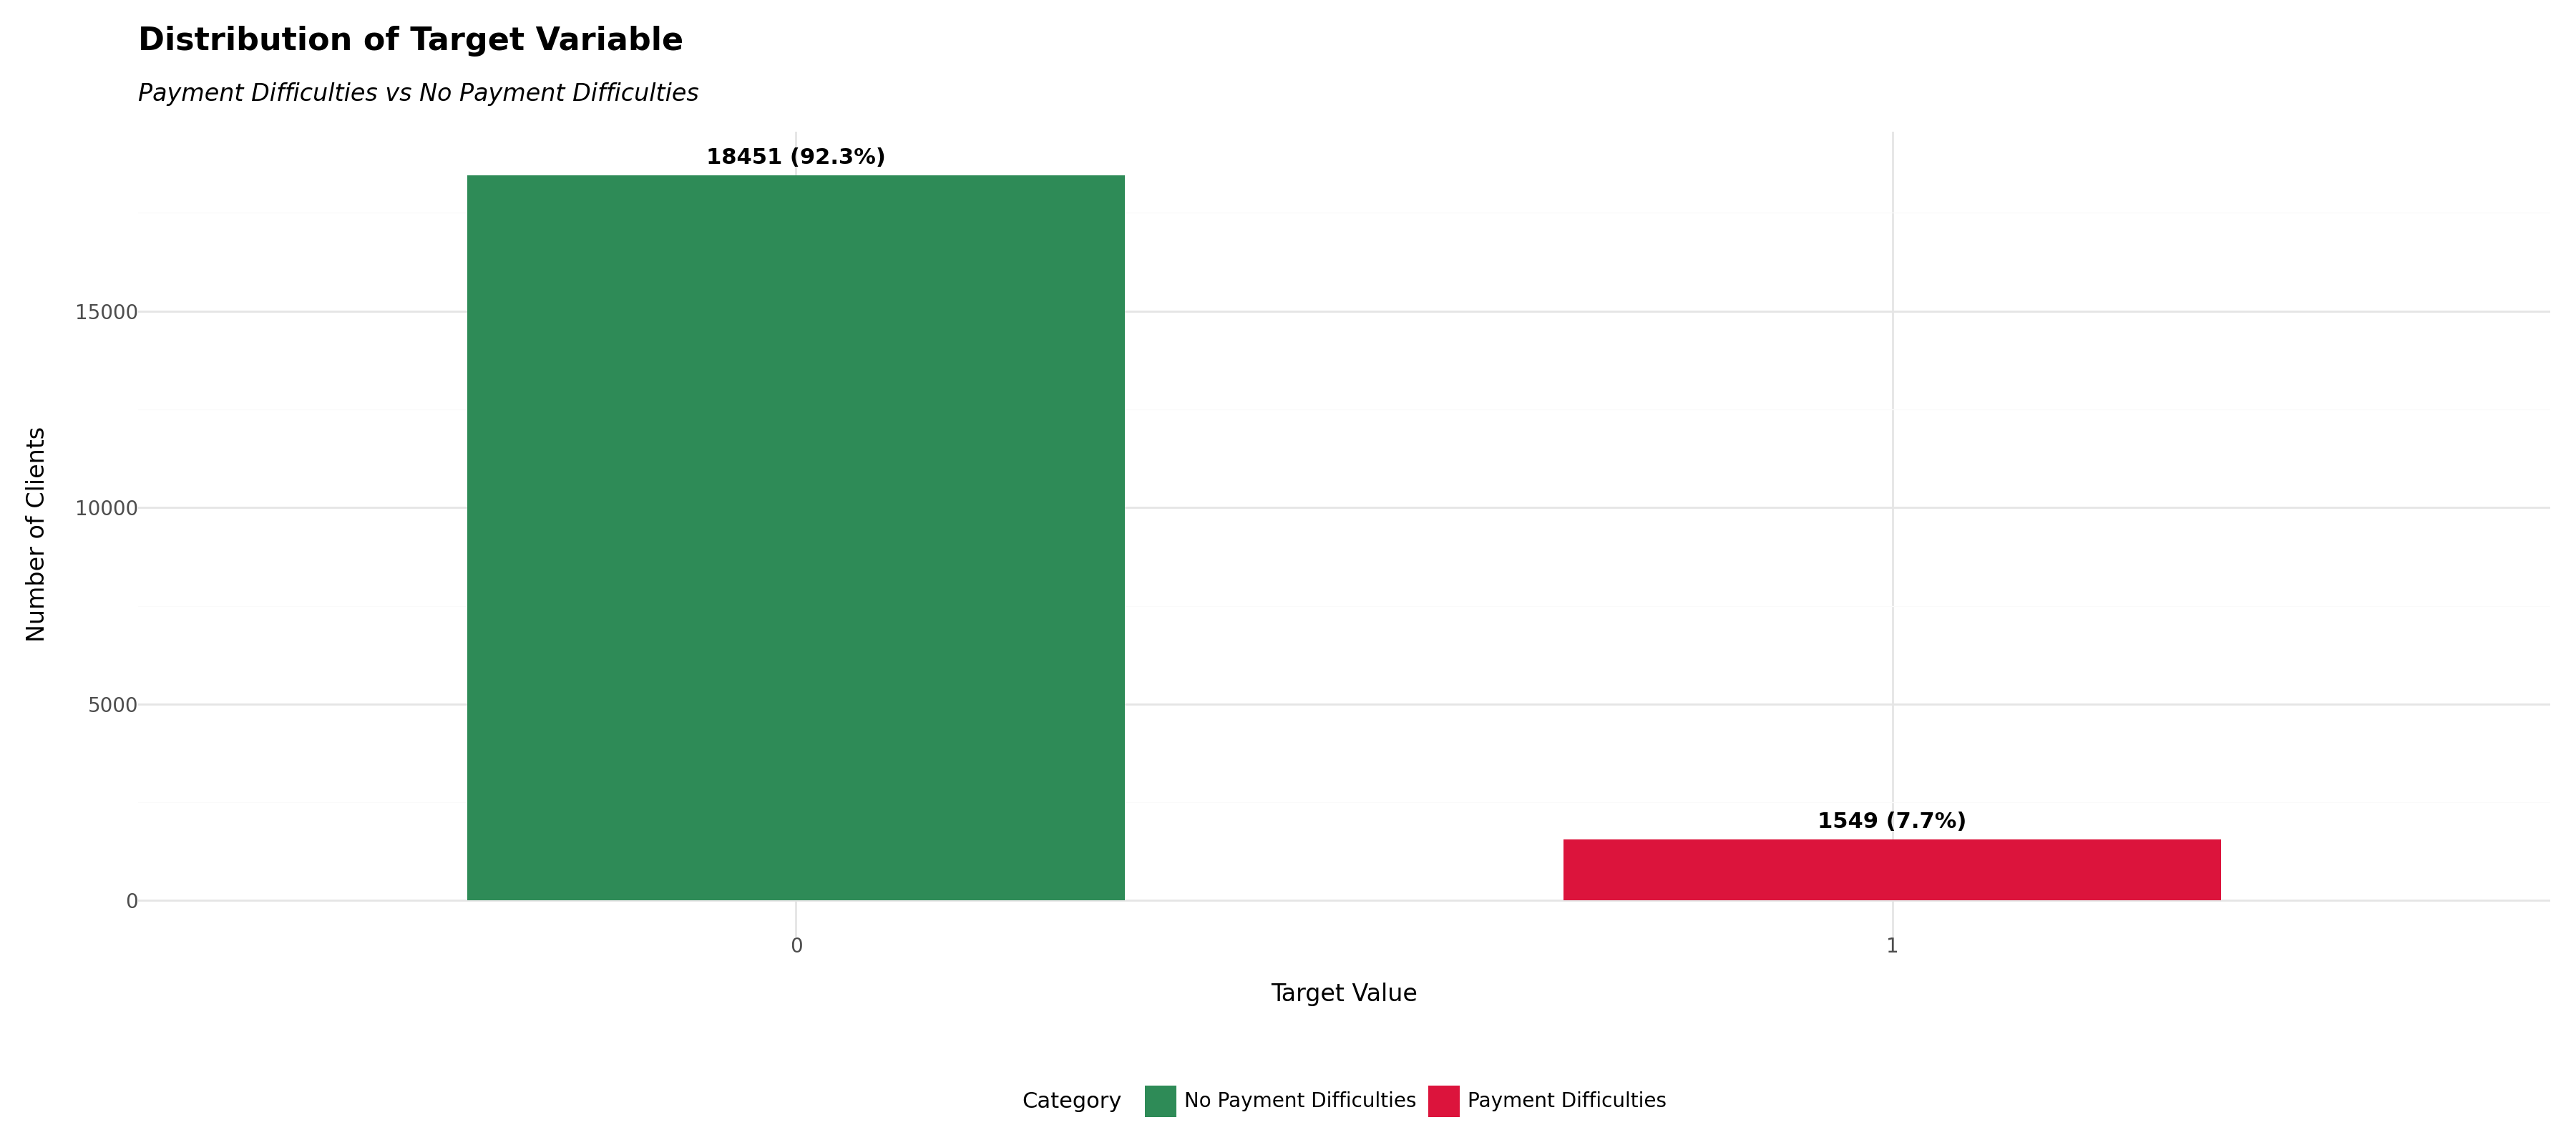

In [240]:
# Add formatted labels to dataframe for display on chart
target_summary['label_text'] = (target_summary['count'].astype(str) + 
                               ' (' + target_summary['percentage'].astype(str) + '%)')

# Create a bar chart to visualize the balance of our outcome variable
plot = (ggplot(target_summary, aes(x='factor(TARGET)', y='count', fill='label')) +
        geom_col(width=0.6) +
        # Add labels showing counts and percentages on the bars
        geom_text(aes(label='label_text'), 
                 va='bottom', nudge_y=target_summary['count'].max() * 0.01, 
                 size=11, fontweight='bold') +
        # Use green for good outcomes, red for payment difficulties
        scale_fill_manual(values={'No Payment Difficulties': '#2E8B57', 
                                'Payment Difficulties': '#DC143C'}) +
        labs(title='Distribution of Target Variable',
             subtitle='Payment Difficulties vs No Payment Difficulties',
             x='Target Value',
             y='Number of Clients',
             fill='Category'))

plot

In [241]:
# Missing values analysis
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df)) * 100
missing_summary = (pd.DataFrame({
    'Variable': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_pct.values
}).query('Missing_Count > 0')
  .sort_values('Missing_Count', ascending=False))

print("Missing Values Summary:")
print(f"Total variables with missing values: {len(missing_summary)}")
print(f"Variables with >50% missing: {sum(missing_summary['Missing_Percentage'] > 50)}")
print(f"Variables with >20% missing: {sum(missing_summary['Missing_Percentage'] > 20)}")
print()

Missing Values Summary:
Total variables with missing values: 16
Variables with >50% missing: 0
Variables with >20% missing: 1



In [242]:
if len(missing_summary) > 0:
    print("Top 10 variables with most missing values:")
    display(missing_summary.head(10).round(2))
else:
    print("No missing values found in the dataset.")

Top 10 variables with most missing values:


,Variable,Missing_Count,Missing_Percentage
25,OCCUPATION_TYPE,6290,31.45
39,EXT_SOURCE_3,3945,19.73
67,AMT_REQ_CREDIT_BUREAU_YEAR,2701,13.50
66,AMT_REQ_CREDIT_BUREAU_QRT,2701,13.50
64,AMT_REQ_CREDIT_BUREAU_WEEK,2701,13.50
65,AMT_REQ_CREDIT_BUREAU_MON,2701,13.50
62,AMT_REQ_CREDIT_BUREAU_HOUR,2701,13.50
63,AMT_REQ_CREDIT_BUREAU_DAY,2701,13.50
10,NAME_TYPE_SUITE,81,0.40
40,OBS_30_CNT_SOCIAL_CIRCLE,54,0.27


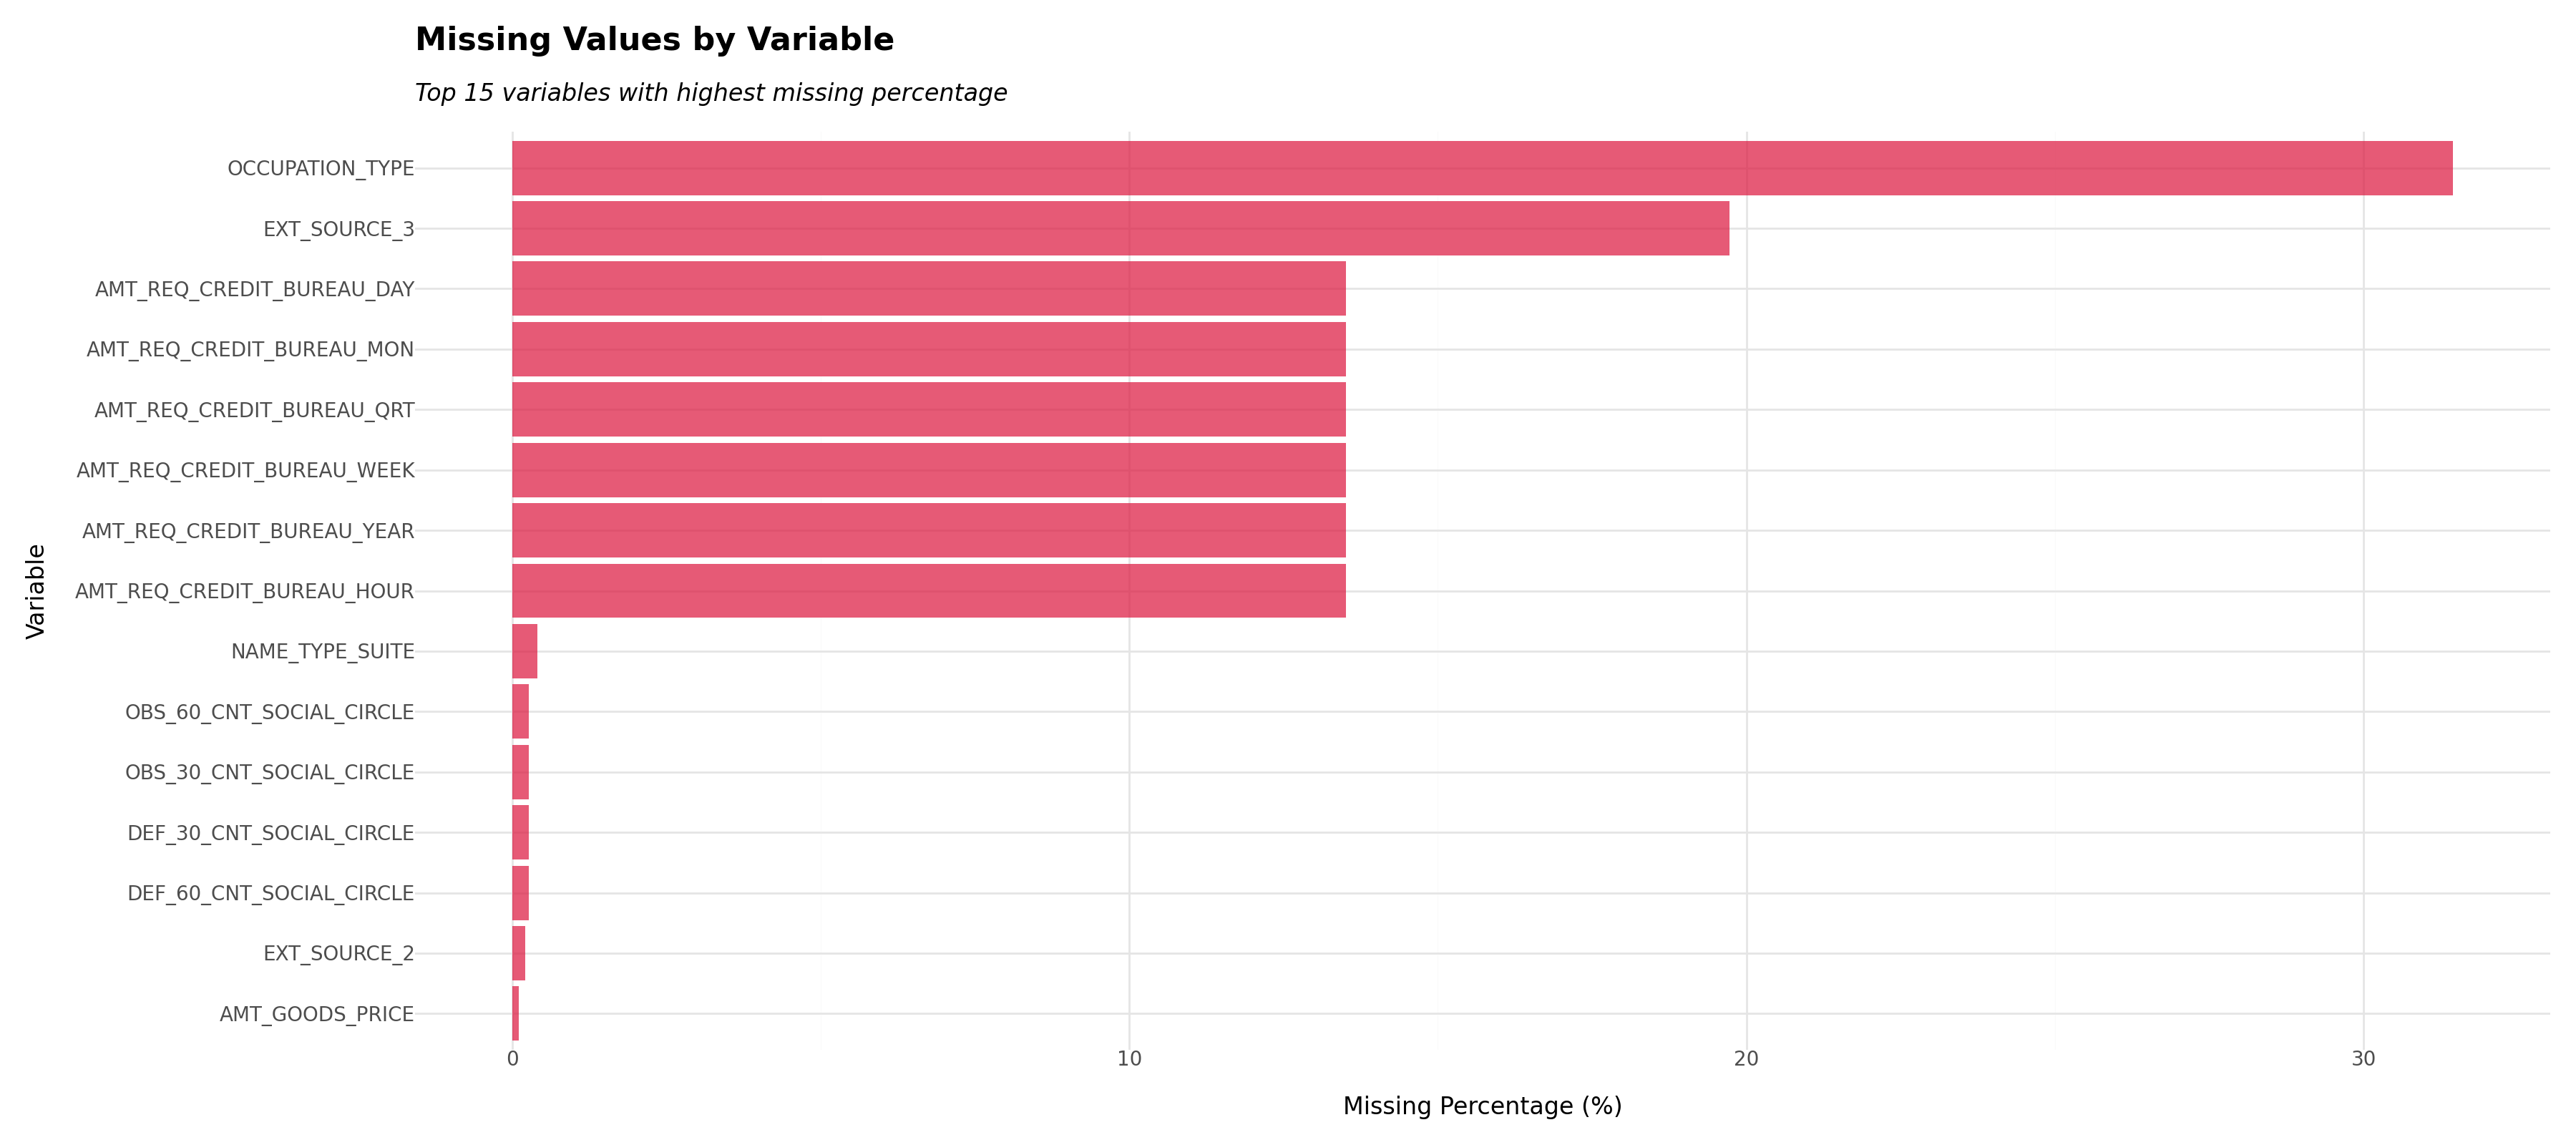

In [243]:
if len(missing_summary) > 0:
    top_missing = missing_summary.head(15)  # Top 15
    
    plot = (ggplot(top_missing, aes(x='reorder(Variable, Missing_Percentage)', y='Missing_Percentage')) +
            geom_col(fill='#DC143C', alpha=0.7) +
            coord_flip() +
            labs(title='Missing Values by Variable',
                 subtitle='Top 15 variables with highest missing percentage',
                 x='Variable',
                 y='Missing Percentage (%)'))
else:
    print("No missing values to visualize.")
plot

In [244]:
# duplicate rows analysis
duplicate_count = df.duplicated().sum()
pd.DataFrame({'Duplicate_Rows': [duplicate_count]})

,Duplicate_Rows
0,0


In [245]:
# Simple outlier counts for key money fields
key_money = [c for c in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY'] if c in df.columns]
out_rows = []
for col in key_money:
    s = df[col].dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_count = int(((s < low) | (s > high)).sum())
    out_pct = round(out_count / len(s) * 100, 2)
    out_rows.append({'column': col, 'outliers': out_count, 'pct': out_pct})

pd.DataFrame(out_rows)

,column,outliers,pct
0,AMT_INCOME_TOTAL,882,4.41
1,AMT_CREDIT,451,2.25
2,AMT_ANNUITY,498,2.49


## 3. Missing Value Handling (Andrew's Work)
**Role:** Advanced EDA Analyst & Basic Preprocessing Specialist

Andrew: Base cleaning, missing values, binning, and categorical encoding.


In [246]:
# What we do here
# - Drop duplicates
# - Optional date handling to create days-ago features
# - Identify categorical and numeric columns
# - Bin rare categories for high-cardinality columns only
# - Impute missing values (numeric median, categorical most frequent)
# - One hot encode categorical with sklearn
# - Save clean_base and encoded_for_model

In [247]:
# Work on a copy
work = df.copy()

# Drop exact duplicates
work = work.drop_duplicates().reset_index(drop=True)

In [248]:
def categorical_summary(work: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
    cats = work.select_dtypes(include=["object", "category"])
    rows = []
    for col in cats.columns:
        vc = cats[col].value_counts(dropna=False).head(top_n)
        for k, v in vc.items():
            rows.append({"column": col, "value": k, "count": int(v)})
    return pd.DataFrame(rows)

cat_summary = categorical_summary(work, top_n=8)
cat_summary

,column,value,count
0,NAME_CONTRACT_TYPE,Cash loans,18089
1,NAME_CONTRACT_TYPE,Revolving loans,1911
2,CODE_GENDER,F,13189
3,CODE_GENDER,M,6811
4,FLAG_OWN_CAR,N,13213
...,...,...,...
58,ORGANIZATION_TYPE,Other,1115
59,ORGANIZATION_TYPE,Medicine,716
60,ORGANIZATION_TYPE,Business Entity Type 2,703
61,ORGANIZATION_TYPE,Government,663


In [249]:
# Optional date handling: if any *_DATE fields exist, create _DAYS_AGO
date_like = [c for c in work.columns if 'DATE' in c.upper()]
for c in date_like:
    try:
        work[c] = pd.to_datetime(work[c], errors='coerce')
        ref = work[c].max()
        work[f'{c}_DAYS_AGO'] = (ref - work[c]).dt.days
    except Exception:
        pass

In [250]:
# Identify column types
cat_cols = work.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = work.select_dtypes(include=['number']).columns.tolist()

# Do not include the target among features
TARGET = 'TARGET'
if TARGET in cat_cols:
    cat_cols.remove(TARGET)
if TARGET in num_cols:
    num_cols.remove(TARGET)

In [251]:
rare_threshold = 0.02
high_cardinality_min_unique = 20

In [252]:
# Find high-cardinality categorical columns
high_card_cols = [c for c in cat_cols if work[c].nunique(dropna=False) >= high_cardinality_min_unique]
low_card_cols  = [c for c in cat_cols if c not in high_card_cols]

print("High-cardinality cats:", high_card_cols)
print("Low-cardinality cats:", low_card_cols)

High-cardinality cats: ['ORGANIZATION_TYPE']
Low-cardinality cats: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START']


In [253]:
# Bin rare categories only in high-cardinality columns
# Any category with share < rare_threshold becomes "Other"
for col in high_card_cols:
    freq = work[col].value_counts(normalize=True, dropna=False)
    rare_values = freq[freq < rare_threshold].index
    work[col] = work[col].where(~work[col].isin(rare_values), "Other")

In [254]:
# Define transformations
# For categorical: impute missing with most frequent, then one-hot encode
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


In [255]:
# For numerical: impute missing with median, then scale
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [256]:
# Combine into one transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ],
    remainder="drop"
)

In [257]:
# Apply to the dataset
X = work.drop(columns=[c for c in [TARGET] if c in work.columns])
y = work[TARGET] if TARGET in work.columns else None

X_enc = preprocessor.fit_transform(X)

In [ ]:
# Build encoded DataFrame with column names
feature_names = []
feature_names += num_cols
encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_feature_names = encoder.get_feature_names_out(cat_cols).tolist()
feature_names += cat_feature_names

encoded_df = pd.DataFrame(X_enc, columns=feature_names, index=work.index) # type: ignore
if y is not None:
    encoded_df[TARGET] = y.values

encoded_path = os.path.join(OUT_DIR, 'encoded_for_model.csv')
encoded_df.to_csv(encoded_path, index=False)
print('Saved:', encoded_path)

Saved: processed_data\encoded_for_model.csv


In [259]:
# see sample values
df[cat_cols].sample(5)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
3900,Cash loans,M,Y,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Managers,SATURDAY,Business Entity Type 3
17939,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,SATURDAY,XNA
19949,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Drivers,FRIDAY,Business Entity Type 3
6900,Cash loans,M,Y,Y,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,Drivers,THURSDAY,Self-employed
14171,Revolving loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,NaN,THURSDAY,Business Entity Type 3


## Feature engineering, clustering, anomalies, and quick feature selection

In [260]:
# read the cleaned data
case_data = pd.read_csv(f'{OUT_DIR}/encoded_for_model.csv')
# see sample values
case_data.sample(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA,TARGET
13502,-0.574552,-0.095075,-1.036675,-1.255635,-0.965387,-0.196110,1.266602,-0.457991,-0.038545,0.218125,0.468442,-0.502108,0.043051,1.616996,-0.24677,-0.165588,1.854954,1.915626,0.900599,-0.124236,-0.232538,-0.20703,-0.28761,-0.545301,-0.464628,-0.183434,0.528611,-0.178419,-0.323284,-0.173027,-0.27858,-1.255673,-0.007071,0.63724,-0.122145,-0.305767,-0.017323,-0.298971,-0.057976,-0.071597,-0.055311,-0.056213,-0.037443,-0.097413,-0.014144,-0.08895,-0.021218,-0.015813,-0.015813,-0.070172,-0.056317,-0.157482,-0.269975,-0.390581,0.694895,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,

In [261]:
# make a copy of the dataframe to avoid SettingWithCopyWarning
case_data = cleaned_df.copy()
# shape of the cleaned data
case_data.shape

(20000, 131)

In [262]:
# Keep target if it exists
target_col = "TARGET"
has_target = target_col in case_data.columns
if has_target:
    y = case_data[target_col].copy()

In [263]:
# make age and employment as years instead of days, create new columns
case_data['YEARS_BIRTH'] = (-case_data['DAYS_BIRTH'] / 365).round(1)
case_data["YEARS_EMPLOYED"] = (-case_data["DAYS_EMPLOYED"] / 365).round(1)

# see sample values
case_data[['DAYS_BIRTH', 'YEARS_BIRTH', 'DAYS_EMPLOYED', 'YEARS_EMPLOYED']].sample(5)

,DAYS_BIRTH,YEARS_BIRTH,DAYS_EMPLOYED,YEARS_EMPLOYED
11027,-0.967224,0.0,-0.475364,0.0
17904,-0.355014,0.0,-0.464469,0.0
12046,1.217351,-0.0,-0.474147,0.0
16841,0.100552,-0.0,-0.460639,0.0
14590,-0.465372,0.0,-0.460200,0.0


In [264]:
# Quick EDA style checks (simple prints)
print("Rows, Cols:", case_data.shape)
if has_target:
    print("Target distribution (mean):", float(case_data[target_col].mean()))
if "DAYS_BIRTH" in case_data.columns:
    print("Age (years) quick stats:", case_data["YEARS_BIRTH"].describe()[["min","mean","50%","max"]].to_dict())
if "AMT_INCOME_TOTAL" in case_data.columns:
    income_bins = pd.cut(case_data["AMT_INCOME_TOTAL"], bins=5)
    if has_target:
        print("Default rate by income bins:\n", case_data.groupby(income_bins)[target_col].mean())

Rows, Cols: (20000, 133)
Target distribution (mean): 0.07745
Age (years) quick stats: {'min': -0.0, 'mean': 0.0, '50%': -0.0, 'max': -0.0}
Default rate by income bins:
 AMT_INCOME_TOTAL
(-1.314, 14.343]    0.077469
(14.343, 29.923]    0.000000
(29.923, 45.502]         NaN
(45.502, 61.081]         NaN
(61.081, 76.66]     0.000000
Name: TARGET, dtype: float64


In [265]:
# Weighted composite metrics (0 to 100 scale)
# Financial_Stress_Index
# Credit_Stability_Index

# Credit over income (0..1), capped
if {"AMT_CREDIT", "AMT_INCOME_TOTAL"}.issubset(case_data.columns):
    credit_over_income = case_data["AMT_CREDIT"] / case_data["AMT_INCOME_TOTAL"].replace(0, np.nan)
    credit_over_income = credit_over_income.clip(0, 10) / 10
    credit_over_income = credit_over_income.fillna(credit_over_income.median())
else:
    credit_over_income = pd.Series(0.0, index=case_data.index)

In [204]:
# Short employment flag (less than 1 year)
if "YEARS_EMPLOYED" in case_data.columns:
    short_employment = (case_data["YEARS_EMPLOYED"].fillna(0) < 1).astype(int)
else:
    short_employment = pd.Series(0, index=case_data.index)

# No realty flag
if "FLAG_OWN_REALTY" in case_data.columns:
    own_r = case_data["FLAG_OWN_REALTY"].map({"Y": 1, "N": 0, 1: 1, 0: 0}).fillna(0)
    no_realty = 1 - own_r
else:
    no_realty = pd.Series(0, index=case_data.index)

In [205]:
# Financial Stress Index (weights 0.4 / 0.3 / 0.3), then scale to 0..100
case_data["Financial_Stress_Index"] = (0.4 * credit_over_income + 0.3 * short_employment + 0.3 * no_realty) * 100
case_data["Financial_Stress_Index"] = case_data["Financial_Stress_Index"].clip(0, 100)

# Credit Stability Index from age and income, 0..100
if "Age_Years" in case_data.columns:
    age_stability = (case_data["Age_Years"].clip(18, 65) - 18) / (65 - 18)
else:
    age_stability = pd.Series(0.5, index=case_data.index)

if "AMT_INCOME_TOTAL" in case_data.columns:
    income_stability = (case_data["AMT_INCOME_TOTAL"] / 1_000_000).clip(0, 1)
else:
    income_stability = pd.Series(0.0, index=case_data.index)

case_data["Credit_Stability_Index"] = (0.5 * age_stability + 0.5 * income_stability) * 100
case_data["Credit_Stability_Index"] = case_data["Credit_Stability_Index"].clip(0, 100)

print("Added Financial_Stress_Index and Credit_Stability_Index.")

Added Financial_Stress_Index and Credit_Stability_Index.


In [206]:
# Group binning and percentile ranks
# Example: map education to simple groups and make percentiles

# Education simple groups if available
if "NAME_EDUCATION_TYPE" in case_data.columns:
    edu_map = {
        "Secondary / secondary special": "Basic",
        "Lower secondary": "Basic",
        "Incomplete higher": "Intermediate",
        "Higher education": "Advanced",
        "Academic degree": "Advanced"
    }
    case_data["Education_Group"] = case_data["NAME_EDUCATION_TYPE"].map(edu_map).fillna("Other")

# Percentile ranks for key money fields
rank_cols = [c for c in ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY"] if c in case_data.columns]
for c in rank_cols:
    s = case_data[c].fillna(case_data[c].median())
    case_data[f"{c}_PCTL"] = s.rank(pct=True) * 100

if len(rank_cols) > 0 and all(f"{c}_PCTL" in case_data.columns for c in rank_cols):
    case_data["Financial_Profile_Score"] = case_data[[f"{c}_PCTL" for c in rank_cols]].mean(axis=1)
else:
    case_data["Financial_Profile_Score"] = np.nan

print("Added education groups, percentiles, and Financial_Profile_Score.")

Added education groups, percentiles, and Financial_Profile_Score.


In [ ]:
# ---------------------------------------------------------
# Simple K-Means clusters for risk segments
# ---------------------------------------------------------
cluster_cols = [c for c in ["Financial_Stress_Index", "Credit_Stability_Index", "AMT_INCOME_TOTAL", "Age_Years", "AMT_CREDIT"] if c in case_data.columns]

if len(cluster_cols) > 0:
    Xc = case_data[cluster_cols].fillna(0.0).values
    scaler = StandardScaler()
    Xc_scaled = scaler.fit_transform(Xc)

    kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
    case_data["Risk_Cluster"] = kmeans.fit_predict(Xc_scaled)
else:
    case_data["Risk_Cluster"] = -1

print("Added Risk_Cluster.")

  File "c:\Users\rkisyula.CORP\AppData\Local\anaconda3\envs\DDC\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\rkisyula.CORP\AppData\Local\anaconda3\envs\DDC\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rkisyula.CORP\AppData\Local\anaconda3\envs\DDC\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\rkisyula.CORP\AppData\Local\anaconda3\envs\DDC\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Added Risk_Cluster.


In [208]:
# ---------------------------------------------------------
# 5) Isolation Forest for anomaly detection
# ---------------------------------------------------------
anom_cols = [c for c in ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "Financial_Stress_Index", "Credit_Stability_Index"] if c in case_data.columns]
if len(anom_cols) > 0:
    Xa = case_data[anom_cols].fillna(0.0).values
    iso = IsolationForest(contamination=0.10, random_state=42)
    iso_pred = iso.fit_predict(Xa)
    case_data["Anomaly_Score"] = iso.decision_function(Xa)
    case_data["Is_Anomaly"] = (iso_pred == -1)
else:
    case_data["Anomaly_Score"] = 0.0
    case_data["Is_Anomaly"] = False

if has_target:
    normal_rate = case_data.loc[~case_data["Is_Anomaly"], target_col].mean()
    anom_rate = case_data.loc[case_data["Is_Anomaly"], target_col].mean()
    print(f"Default rate normal: {normal_rate:.3f}")
    print(f"Default rate anomalies: {anom_rate:.3f}")

print("Added anomaly flags.")


Default rate normal: 0.080
Default rate anomalies: 0.057
Added anomaly flags.


In [209]:
# ---------------------------------------------------------
# Simple interaction and ratio features + document completeness
# ---------------------------------------------------------

# Products
if {"AMT_INCOME_TOTAL", "AMT_CREDIT"}.issubset(case_data.columns):
    case_data["Income_Credit_Product"] = case_data["AMT_INCOME_TOTAL"] * case_data["AMT_CREDIT"]

if {"Age_Years", "AMT_INCOME_TOTAL"}.issubset(case_data.columns):
    case_data["Age_Income_Product"] = case_data["Age_Years"] * case_data["AMT_INCOME_TOTAL"]

# Ratios (+1 to avoid divide by zero)
if {"AMT_CREDIT", "AMT_GOODS_PRICE"}.issubset(case_data.columns):
    case_data["Credit_to_Goods_Ratio"] = case_data["AMT_CREDIT"] / (case_data["AMT_GOODS_PRICE"] + 1)

if {"AMT_ANNUITY", "AMT_CREDIT"}.issubset(case_data.columns):
    case_data["Annuity_to_Credit_Ratio"] = case_data["AMT_ANNUITY"] / (case_data["AMT_CREDIT"] + 1)

# Document completeness
doc_cols = [c for c in case_data.columns if c.startswith("FLAG_DOCUMENT")]
if len(doc_cols) > 0:
    case_data["Document_Completeness_Rate"] = case_data[doc_cols].mean(axis=1)

print("Added interactions, ratios, and document completeness.")

Added interactions, ratios, and document completeness.


In [210]:
# ---------------------------------------------------------
# 7) Quick feature selection (numeric only to keep it simple)
#    Step 1: filter with ANOVA F-test
#    Step 2: rank with RandomForest importance
# ---------------------------------------------------------
selected_features = []
if has_target:
    X_num = case_data.drop(columns=[target_col]).select_dtypes(include=[np.number]).fillna(0)
    y_num = y

    if X_num.shape[1] > 0:
        k_keep = min(200, X_num.shape[1])
        selector = SelectKBest(score_func=f_classif, k=k_keep)
        X_sel = selector.fit_transform(X_num, y_num)
        sel_cols = X_num.columns[selector.get_support()].tolist()

        rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
        rf.fit(X_num[sel_cols], y_num)
        imp = pd.Series(rf.feature_importances_, index=sel_cols).sort_values(ascending=False)

        selected_features = imp.head(min(75, len(imp))).index.tolist()
        print("Top 10 selected features:", selected_features[:10])


NameError: name 'SelectKBest' is not defined

In [211]:
# ---------------------------------------------------------
# 8) Save outputs for the team
# ---------------------------------------------------------
os.makedirs("outputs/engineered", exist_ok=True)
case_data.to_csv("outputs/engineered/engineered.csv", index=False)

import json
with open("outputs/engineered/selected_feature_list.json", "w") as f:
    json.dump({"selected_features": selected_features}, f, indent=2)

print("Saved: outputs/engineered/engineered.csv")
print("Saved: outputs/engineered/selected_feature_list.json")
print("Done.")

Saved: outputs/engineered/engineered.csv
Saved: outputs/engineered/selected_feature_list.json
Done.


**Why These Steps Are Critical for Our Dataset:**

1. **Missing Value Strategy**: Our loan dataset has systematic missing patterns in employment and credit bureau data that need domain-informed handling
2. **Class Imbalance Focus**: With only ~7.7% default cases, we need specialized sampling and evaluation strategies  
3. **Bias Prevention**: Loan decisions have strict regulatory requirements (FCRA, ECOA) - fairness is mandatory
4. **Financial Ratios**: Customers vary in income and credit needs - raw amounts would bias toward high-income segments
5. **Feature Engineering**: Transform raw financial data into meaningful risk indicators (debt-to-income, employment stability)
6. **Quality Assurance**: Systematic checks prevent model failures from data quality issues
7. **Risk-Based Segmentation**: Different risk profiles require different evaluation approaches and intervention strategies

This systematic Python approach, adapted from healthcare competition methodology, provides a robust foundation for our loan default prediction model while ensuring regulatory compliance and interpretability.

### Key Insights for Our Case Competition:

**1. Systematic Methodology**: The winning team used a methodical, well-documented approach with clear rationale for every decision

**2. Fairness as Core Requirement**: They built systematic bias prevention rather than hoping for fairness - critical for loan models with regulatory requirements

**3. Domain-Informed Feature Engineering**: Success came from understanding healthcare workflows and patient journeys, not just statistical methods - we need similar understanding of credit risk and borrower behavior

**4. Multi-Phase Approach**: They recognized different patient groups need different intervention timing - we should consider pre-approval vs post-approval risk factors

**5. Interpretability Focus**: Emphasis on understanding "why" rather than just predicting "who" enabled actionable business recommendations

**6. Business Impact Validation**: They measured success through healthcare outcomes and cost savings, not just model metrics - we should validate through portfolio performance

These insights will guide our preprocessing strategy to create a fair, interpretable, and business-valuable loan default prediction model that follows proven competition-winning methodologies.